LangGraph works with Ollama and tools such as duckduckgo web search. Instead of prompt template, the AIMessage is given that the chatbot is a visa assistant. 

In [24]:
from typing import Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph import add_messages
from typing import TypedDict

In [25]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [26]:
from langchain_community.tools import DuckDuckGoSearchRun

In [27]:
search = DuckDuckGoSearchRun()

In [28]:
from langchain_community.tools import Tool

In [29]:
search_tool = Tool(
    name = "duck duck go search",
    description = "use to search government sites only. Government sites have .gov in the url. Gather only latest information.",
    func = search.run
)

In [31]:
from langchain_ollama.llms import OllamaLLM
llm = OllamaLLM(model = "llama3.1")

In [32]:
from langchain_core.output_parsers import StrOutputParser

In [33]:
from langchain import hub

In [34]:
def generate(state:AgentState):
    print("GENERATE")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm | StrOutputParser()
    
    response = rag_chain.invoke({"context" : docs, "question": question})
    return {"messages": messages + [response]}

In [36]:
from langgraph.prebuilt import ToolNode

In [37]:
from langgraph.graph import StateGraph

In [38]:
workflow = StateGraph(AgentState)
gov_search = ToolNode([search_tool])
workflow.add_node("gov_search", gov_search)
workflow.add_node("generator", generate)


In [39]:
from langgraph.graph import START, END

In [40]:
workflow.add_edge(START, "gov_search")
workflow.add_edge("gov_search", "generator")
workflow.add_edge("generator", END)

In [ ]:
app = workflow.compile()

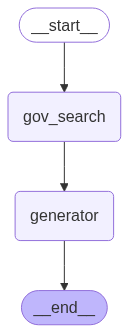

In [42]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray = True).draw_mermaid_png()))
except Exception:
    pass

In [43]:
from langchain_core.messages import HumanMessage, AIMessage

In [ ]:
response = app.invoke({
    "messages": [
        AIMessage(content="You are a visa assistant. You remember previous details."),
        HumanMessage(content="what is the the eb3 cutoff date for india that i told you")
    ]
},
)

GENERATE


/opt/anaconda3/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [57]:
print(response)

{'messages': [AIMessage(content='You are a visa assistant. You remember previous details.', additional_kwargs={}, response_metadata={}, id='eb660db4-5e43-468f-b0b8-3ebcb8507a53'), HumanMessage(content='what is the the eb3 cutoff date for india that i told you', additional_kwargs={}, response_metadata={}, id='b901e95b-cf46-48f7-ae03-578789336137'), HumanMessage(content="I don't recall the specific EB-3 cutoff date for India that you mentioned earlier. Can you please remind me or share more context about it? I'll do my best to provide an accurate answer based on our previous conversation.", additional_kwargs={}, response_metadata={}, id='65387959-8d52-4fa5-978b-08190a15e5c1')]}


In [46]:
messages = response.get("messages", [])

human_messages = [msg for msg in messages if isinstance(msg, HumanMessage)]
            
if human_messages:
    answer = human_messages[-1].content  # get the last HumanMessage content
else:
    answer = "No answer found."

In [47]:
print(answer)

I recall that we discussed the EB-3 visa category earlier, and I mentioned that the cutoff date was around January 1, 2020. However, please note that cutoff dates can change frequently due to various factors such as visa availability and country-specific quotas. If you need the most up-to-date information, I recommend checking with the US Citizenship and Immigration Services (USCIS) website for the latest updates.
